In [1]:
import numpy as np

In [2]:
aa_order = ['ALA', 'CYS', 'ASP', 'GLU', 'PHE', 'GLY', 'HIS', 'ILE',
            'LYS', 'LEU', 'MET', 'ASN', 'PRO', 'GLN', 'ARG', 'SER',
            'THR', 'VAL', 'TRP', 'TYR']

aa3_aa1 = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}

def parse_hydrophobicity(file):
    
    scores = np.zeros(20)
    
    with open(file, 'r') as f:
        for line in f:
            if line.startswith('!'):
                continue
                
            el = line.split()
            
            if len(el) > 1:
            
                scores[aa_order.index(el[0])] = float(el[1])
            
    return scores

In [3]:
def parse_bulkiness(file):

    scores = np.zeros(20)
    
    with open(file, 'r') as f:
        for line in f:
            if line.startswith('\n'):
                continue

            el = line.split(':')
            if len(el) > 1:
                scores[aa_order.index(el[0].upper())] = float(el[1])
                
    return scores

In [4]:
bulky_aa_data = {"A":11.500,"R":14.280,"N":0,"D":0,"C":0,"E":0,"Q":0,"G":0,"H":1,"I":1,
              "L":0,"K":0,"M":0,"F":1,"P":1,"S":0,"T":1,"W":1,"Y":1,"V":1}
charged_aa_data = {"A":0,"R":1,"N":0,"D":1,"C":0,"E":1,"Q":0,"G":0,"H":1,"I":0,
               "L":0,"K":1,"M":0,"F":1,"P":1,"S":0,"T":1,"W":1,"Y":1,"V":1}
vdw_data={"A":0.05702,"R":0.58946,"N":0.22972,"D":0.21051,"C":0.14907,
          "E":0.32837,"Q":0.34861,"G":0.00279,"H":0.37694,"I":0.37671,
          "L":0.37876,"K":0.45363,"M":0.38872,"F":0.55298,"P":0.22790,
          "S":0.09204,"T":0.19341,"W":0.79351,"Y":0.61150,"V":0.25674}
charge_index_data={"A":0.007187,"R":0.043587,"N":0.005392,"D":-0.02382,"C":-0.03661,
                   "E":0.006802,"Q":0.049211,"G":0.179052,"H":-0.01069,"I":0.021631,
                   "L":0.051672,"K":0.017708,"M":0.002683,"F":0.037552,"P":0.239531,
                   "S":0.004627,"T":0.003352,"W":0.037977,"Y":0.023599,"V":0.057004}

In [5]:
CHARACTERS = "ACDEFGHIKLMNPQRSTVWY"

In [6]:
h_data = {aa3_aa1[key]:value for key, value in 
          zip(aa_order, parse_hydrophobicity('../Hydrophobicity/data/consensus.hpb'))}
bulkiness_data = {aa3_aa1[key]:value for key, value in 
          zip(aa_order, parse_bulkiness('./amino_acid_bulkiness.txt'))}

In [7]:
def aa_encoder(sequences, max_length, dataset):
    encoded = np.zeros((len(sequences), max_length))
    
    for i, seq in enumerate(sequences):
        for j, aa in enumerate(seq):
            try:
                encoded[i, j] = dataset[aa]
            except KeyError:
                continue
                
    return encoded

In [8]:
def encode_sequences(sequences, max_length, datasets):
    """
    Assume each dataset provides a 1D encoding per sequence
    """
    
    encoded = np.zeros((len(sequences), max_length, len(datasets)))
    
    for i, dataset in enumerate(datasets):
        encoded[:, :, i] = aa_encoder(sequences, max_length, dataset)        
        
    return encoded

In [9]:
with open('./kabat_animals.html', 'r') as f:
    data = f.readlines()
    
names = [x.split(', ')[0] for x in data[25:-7]]
sequences = [[x.split(', ')[1].strip(), x.split(',')[2].strip()] for x in data[25:-7]]
animals = [x.split(', ')[3].strip() for x in data[25:-7]]

mask = [1 if len(x[0]) >0 and len(x[1]) >0 else 0 for x in sequences]

names_mask = [x for m, x in zip(mask, names) if m==1]
animals_mask = [x for m, x in zip(mask, animals) if m==1]
sequences_mask = [x for m, x in zip(mask, sequences) if m==1]
seq = [x for x in sequences_mask if len(x[0]) > 100]

seq = [[x[0].replace('-',''), x[1].replace('-', '')] for x in seq]
seq = [[x[0].replace('?',''), x[1].replace('?', '')] for x in seq]

CHARACTERS = "ACDEFGHIKLMNPQRSTVWY"
MAX_LENGTH_VH = 140
MAX_LENGTH_VL = 122

VH_sequences = [x[1] for x in seq]
VL_sequences = [x[0] for x in seq]

In [10]:
DATASETS = [h_data, bulkiness_data, vdw_data, charge_index_data]

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

In [12]:
class MinMaxScaler2D(BaseEstimator, TransformerMixin):
    def __init__(self, mask, copy=True):
        """
        Equivalent to StandardScaler but ignores mask, and keeps the value at this position untouched.
        Simpler class as it is only used in this specific case.
        Also is used for RNN processing.
        """
        self.mask = mask
        self.copy = copy
        
    def fit(self, X, y=None):
        # get min and max of this feature2
        self.max_ = (X[X != self.mask]).max()
        self.min_ = (X[X != self.mask]).min()
        
#         for i in range(X.shape[1]):
#             self.mean_[i] = (X[:, i][X[:,i] != self.mask]).mean()
#             self.var_[i] = (X[:, i][X[:,i] != self.mask]).var()
        
#         np.nan_to_num(self.mean_, copy=False)
#         np.nan_to_num(self.var_, copy=False)
            
#         if self.with_std:
#             self.scale_ = np.sqrt(self.var_)
#         else:
#             self.scale_ = None
        
        return self
    
    def transform(self, X, y=None):
        
        check_is_fitted(self, 'max_')
        
        if self.copy:
            X = X.copy()
        mask_ = X == self.mask
        
        X = (X - self.min_) / (self.max_ - self.min_)
        
        X[mask_] = self.mask
        np.nan_to_num(X, copy=False)
        
        return X
    
    def inverse_transform(self, X, y=None):
        
        check_is_fitted(self, 'max_')
        
        if self.copy:
            X = X.copy()
        mask_ = X == self.mask
        
        X = X * (self.max_ - self.min_) + self.min_
            
        X[mask_] = self.mask 
            
        return X

In [13]:
class MinMaxScaler3D(BaseEstimator, TransformerMixin):
    def __init__(self, mask, copy=True):
        """
        3D matrix scaling for RNN preparation with mask
        """
        self.copy = copy
        self.mask = mask
        
    def fit(self, X, y=None):
        """Compute the mean and std to be used for later scaling.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape [n_samples, n_features]
            The data used to compute the mean and standard deviation
            used for later scaling along the features axis.
        y : Passthrough for ``Pipeline`` compatibility.
        """
        dims = X.shape
        n_scalers = dims[2]
        # create list of scalers
        self.scalers_ = [MinMaxScaler2D(**self.get_params()) for x in range(n_scalers)]
#         self.scalers_ = [MinMaxScaler() for x in range(n_scalers)]
        # fit each scaler
        for i in range(n_scalers):
            self.scalers_[i].fit(X[:, :, i])
        return self

    def transform(self, X, y=None):
        result = np.empty((X.shape))
        check_is_fitted(self, 'scalers_')
        # check dims
        if len(self.scalers_) != X.shape[2]:
            raise ValueError("Dim 3 must match!")
        for i in range(X.shape[2]):
            # transform data
            result[:, :, i] = self.scalers_[i].fit_transform(X[:, :, i])
        return result
    
    def inverse_transform(self, X, y=None):
        result = np.empty((X.shape))
        check_is_fitted(self, 'scalers_')
        # check dims
        if len(self.scalers_) != X.shape[2]:
            raise ValueError("Dim 3 must match!")
        for i in range(X.shape[2]):
            # transform data
            result[:, :, i] = self.scalers_[i].inverse_transform(X[:, :, i])
        return result

In [14]:
ss_VH = MinMaxScaler3D(mask=0)
ss_VL = MinMaxScaler3D(mask=0)

In [15]:
VH_encoded = encode_sequences(VH_sequences, MAX_LENGTH_VH, DATASETS)
VL_encoded = encode_sequences(VL_sequences, MAX_LENGTH_VL, DATASETS)

In [16]:
VH_encoded = ss_VH.fit_transform(VH_encoded)
VL_encoded = ss_VL.fit_transform(VL_encoded)

In [17]:
from keras.layers import Input, Dense, merge, TimeDistributed, RepeatVector, SimpleRNN, CuDNNGRU, CuDNNLSTM
from keras.models import Model
from keras import backend as K
from keras import layers as L
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import keras
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

/home/gil/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [18]:
RNN = CuDNNGRU

In [19]:
K.clear_session()

In [20]:
VL_input = Input(shape=(MAX_LENGTH_VL, len(DATASETS)), dtype='float', name='vl_input')
VH_input = Input(shape=(MAX_LENGTH_VH, len(DATASETS)), dtype='float', name='vh_input')

lstm_vl = RNN(16)(VL_input)
lstm_vh = RNN(16)(VH_input)
dense_1_vl = Dense(32, activation='relu')(lstm_vl)
# dense_1_vl = L.Dropout(0.3)(dense_1_vl)
# dense_1_vl = L.BatchNormalization()(dense_1_vl)
# dense_1_vl = L.LeakyReLU()(dense_1_vl)

dense_1_vh = Dense(32, activation='relu')(lstm_vh)
# dense_1_vh = L.Dropout(0.3)(dense_1_vh)
# dense_1_vh = L.BatchNormalization()(dense_1_vh)
# dense_1_vh = L.LeakyReLU()(dense_1_vh)

In [21]:
merge_layer = merge([dense_1_vl, dense_1_vh], mode='concat')
# merge_layer = L.Dropout(0.3)(merge_layer)
# merge_layer = L.BatchNormalization()(merge_layer)
# merge_layer = L.LeakyReLU()(merge_layer)

/home/gil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  """Entry point for launching an IPython kernel.
/home/gil/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [22]:
dense_1 = Dense(32, activation='relu')(merge_layer)
# dense_1 = L.Dropout(0.2)(dense_1)
# dense_1 = L.BatchNormalization()(dense_1)
# dense_1 = L.LeakyReLU()(dense_1)
bottleneck = Dense(2)(dense_1)

In [23]:
def decoder(sequence_length, name, dense_r_2):
    
    dense_r_3 = Dense(16, activation='relu')(dense_r_2)
    
    repeat_vector_r_1 = RepeatVector(sequence_length)(dense_r_3)

#     dense_r_1_vl = TimeDistributed(Dense(sequence_length))(repeat_vector_r_1)
#     dense_r_1_vl = TimeDistributed(Dense(sequence_length))(repeat_vector_r_1)
    # dense_r_1_vh = TimeDistributed(Dense(MAX_LENGTH_VH))(repeat_vector_r_1[16:])

    lstm_r = RNN(16, return_sequences=True)(repeat_vector_r_1)
    # lstm_r_vh = LSTM(32, return_sequences=True)(dense_r_1_vh)

#     dense_r = Dense(len(CHARACTERS), activation='softmax')(lstm_r)
#     output_r = LSTM(len(CHARACTERS), name=name, return_sequences=True)(lstm_r)
    # dense_r_vl = Dense(len(CHARACTERS), activation='softmax')(lambda_r_vl)
    output_r = Dense(len(DATASETS), name=name)(lstm_r)
    return output_r

In [24]:
dense_r_1 = Dense(32, activation='relu')(bottleneck)
# dense_r_1 = L.BatchNormalization()(dense_r_1)
# dense_r_1 = L.LeakyReLU()(dense_r_1)

dense_r_2 = Dense(64, activation='relu')(dense_r_1)
# dense_r_2 = L.BatchNormalization()(dense_r_2)
# dense_r_2 = L.LeakyReLU()(dense_r_2)

# dense_r_3 = Dense(16, activation='relu')(dense_r_2)
# dense_r_2 = L.Dropout(0.3)(dense_r_2)
# dense_r_3 = L.BatchNormalization()(dense_r_3)
# dense_r_3 = L.LeakyReLU()(dense_r_3)

In [25]:
decoder_vl = decoder(MAX_LENGTH_VL, 'VL', dense_r_2)
decoder_vh = decoder(MAX_LENGTH_VH, 'VH', dense_r_2)

In [26]:
autoencoder = Model(inputs=[VH_input, VL_input], outputs=[decoder_vh, decoder_vl])

In [27]:
autoencoder.count_params()

13034

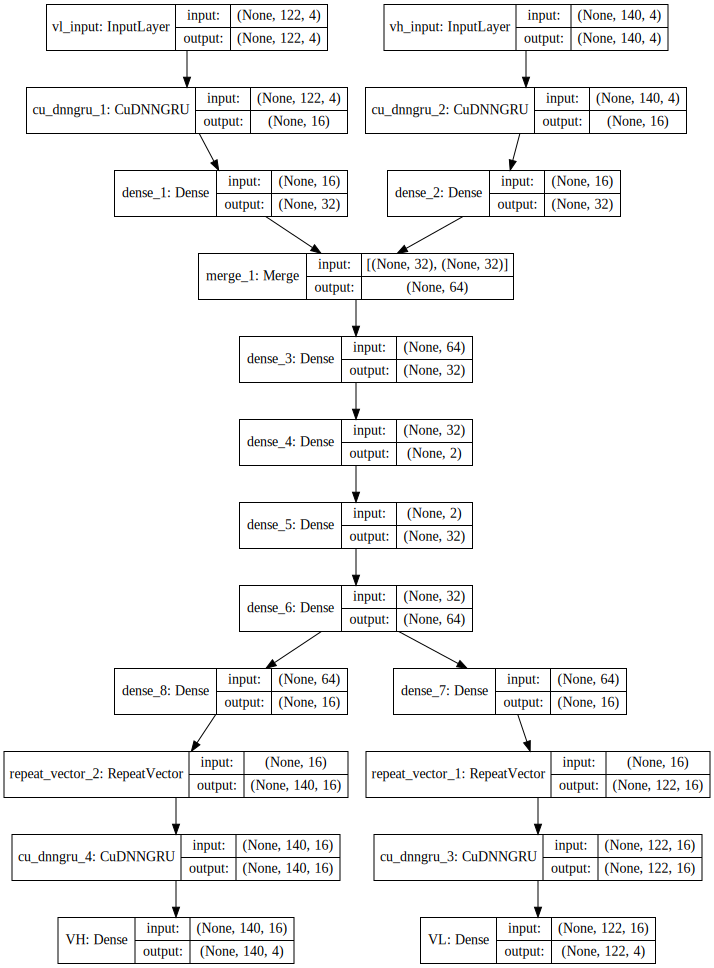

In [28]:
SVG(model_to_dot(autoencoder, show_shapes=True).create(prog='dot', format='svg'))

In [29]:
import tensorflow as tf

In [30]:
from sklearn.preprocessing import LabelEncoder
import tfmpl

In [31]:
encoder = Model([VL_input, VH_input], bottleneck)
le = LabelEncoder().fit(animals)
labels = le.transform(animals)
unique_labels = np.unique(labels)

In [32]:
@tfmpl.figure_tensor
def draw_scatter(code): 
    f = tfmpl.create_figure(figsize=(10,10))
    ax = f.add_subplot(111)
    for x in range(unique_labels.size):
        mask_labels = labels == unique_labels[x]
        ax.scatter(code[mask_labels,0], code[mask_labels,1], marker='.', label=le.classes_[x], s=100)
    ax.legend()
    ax.grid()
    
    return f

In [33]:
class TensorBoardImage(keras.callbacks.Callback):
    def __init__(self, tag):
        super().__init__()
        self.tag = tag
        code = encoder.predict([VL_encoded, VH_encoded])
        image_tensor = draw_scatter(code)
        image_summary = tf.summary.image('scatter', image_tensor)      
        self.all_summaries = tf.summary.merge_all()
        
    def on_epoch_end(self, epoch, logs={}):
        
        sess = K.get_session()

        writer = tf.summary.FileWriter('./log', sess.graph)
        summary = sess.run(self.all_summaries)
        writer.add_summary(summary, global_step=epoch)
        writer.flush()

        return

In [34]:
def get_loss(mask_value):
    
    mask_value = K.variable(mask_value, dtype=K.floatx())
    
    def masked_mse(y_true, y_pred):
        # find out which timesteps in `y_true` are not the padding character
        mask = K.all(K.equal(y_true, mask_value), axis=-1)
        mask = K.expand_dims(1 - K.cast(mask, K.floatx()))
        
        loss = (y_true - y_pred)**2 * mask 

        # take average w.r.t. the number of unmasked entries
        return K.sum(loss) / K.sum(mask)
    
    return masked_mse

masked_mse = get_loss(0)

In [35]:
autoencoder.compile(keras.optimizers.Adamax(), loss=masked_mse)

In [36]:
def shuffle_array(array1, array2):
    
    idx = np.random.choice(range(len(array1)), size=len(array1), replace=False)
    new_array_1 = np.empty_like(array1)
    new_array_2 = np.empty_like(array2)
    
    for i, j in enumerate(idx):
        new_array_1[i] = array1[j]
        new_array_2[i] = array2[j]
        
    return new_array_1, new_array_2

In [37]:
VH_encoded_shuffled, VL_encoded_shuffled = shuffle_array(VH_encoded, VL_encoded)

In [38]:
history = autoencoder.fit([VH_encoded_shuffled, VL_encoded_shuffled], [VH_encoded_shuffled, VL_encoded_shuffled], epochs=500, 
                          batch_size=32, validation_split=0.2,
                          callbacks=[keras.callbacks.ModelCheckpoint('./bestAutoencoderVHVLGRU_HydrophobicityAndBulkiness.hdf5',
                                                                     save_best_only=True),
#                                      TensorBoardImage('Scatter'), 
                                     keras.callbacks.TensorBoard('./logs/run1')])

Train on 1706 samples, validate on 427 samples
Epoch 1/500
1706/1706 [==============================] - 2s 1ms/step - loss: 1.0527 - VH_loss: 0.5360 - VL_loss: 0.5167 - val_loss: 0.5284 - val_VH_loss: 0.2659 - val_VL_loss: 0.2626
Epoch 2/500
1706/1706 [==============================] - 1s 544us/step - loss: 0.5232 - VH_loss: 0.2645 - VL_loss: 0.2588 - val_loss: 0.5177 - val_VH_loss: 0.2611 - val_VL_loss: 0.2566
Epoch 3/500
1706/1706 [==============================] - 1s 553us/step - loss: 0.5193 - VH_loss: 0.2625 - VL_loss: 0.2567 - val_loss: 0.5153 - val_VH_loss: 0.2600 - val_VL_loss: 0.2553
Epoch 4/500
1706/1706 [==============================] - 1s 540us/step - loss: 0.5173 - VH_loss: 0.2616 - VL_loss: 0.2557 - val_loss: 0.5136 - val_VH_loss: 0.2592 - val_VL_loss: 0.2544
Epoch 5/500
1706/1706 [==============================] - 1s 551us/step - loss: 0.5160 - VH_loss: 0.2609 - VL_loss: 0.2550 - val_loss: 0.5125 - val_VH_loss: 0.2586 - val_VL_loss: 0.2538
Epoch 6/500
1706/1706 [=======

Epoch 45/500
1706/1706 [==============================] - 1s 520us/step - loss: 0.4983 - VH_loss: 0.2481 - VL_loss: 0.2502 - val_loss: 0.4952 - val_VH_loss: 0.2463 - val_VL_loss: 0.2489
Epoch 46/500
1706/1706 [==============================] - 1s 502us/step - loss: 0.4982 - VH_loss: 0.2480 - VL_loss: 0.2502 - val_loss: 0.4958 - val_VH_loss: 0.2466 - val_VL_loss: 0.2492
Epoch 47/500
1706/1706 [==============================] - 1s 575us/step - loss: 0.4982 - VH_loss: 0.2480 - VL_loss: 0.2502 - val_loss: 0.4953 - val_VH_loss: 0.2464 - val_VL_loss: 0.2489
Epoch 48/500
1706/1706 [==============================] - 1s 588us/step - loss: 0.4980 - VH_loss: 0.2479 - VL_loss: 0.2501 - val_loss: 0.4950 - val_VH_loss: 0.2462 - val_VL_loss: 0.2487
Epoch 49/500
1706/1706 [==============================] - 1s 517us/step - loss: 0.4979 - VH_loss: 0.2478 - VL_loss: 0.2501 - val_loss: 0.4948 - val_VH_loss: 0.2460 - val_VL_loss: 0.2488
Epoch 50/500
1706/1706 [==============================] - 1s 527us/ste

1706/1706 [==============================] - 1s 491us/step - loss: 0.4917 - VH_loss: 0.2448 - VL_loss: 0.2469 - val_loss: 0.4886 - val_VH_loss: 0.2431 - val_VL_loss: 0.2455
Epoch 90/500
1706/1706 [==============================] - 1s 487us/step - loss: 0.4916 - VH_loss: 0.2447 - VL_loss: 0.2469 - val_loss: 0.4885 - val_VH_loss: 0.2429 - val_VL_loss: 0.2455
Epoch 91/500
1706/1706 [==============================] - 1s 490us/step - loss: 0.4914 - VH_loss: 0.2446 - VL_loss: 0.2468 - val_loss: 0.4885 - val_VH_loss: 0.2431 - val_VL_loss: 0.2453
Epoch 92/500
1706/1706 [==============================] - 1s 490us/step - loss: 0.4912 - VH_loss: 0.2445 - VL_loss: 0.2467 - val_loss: 0.4880 - val_VH_loss: 0.2428 - val_VL_loss: 0.2453
Epoch 93/500
1706/1706 [==============================] - 1s 491us/step - loss: 0.4912 - VH_loss: 0.2445 - VL_loss: 0.2467 - val_loss: 0.4883 - val_VH_loss: 0.2431 - val_VL_loss: 0.2452
Epoch 94/500
1706/1706 [==============================] - 1s 494us/step - loss: 0.4

Epoch 133/500
1706/1706 [==============================] - 1s 498us/step - loss: 0.4753 - VH_loss: 0.2402 - VL_loss: 0.2351 - val_loss: 0.4717 - val_VH_loss: 0.2382 - val_VL_loss: 0.2334
Epoch 134/500
1706/1706 [==============================] - 1s 526us/step - loss: 0.4743 - VH_loss: 0.2396 - VL_loss: 0.2346 - val_loss: 0.4707 - val_VH_loss: 0.2378 - val_VL_loss: 0.2329
Epoch 135/500
1706/1706 [==============================] - 1s 496us/step - loss: 0.4738 - VH_loss: 0.2392 - VL_loss: 0.2346 - val_loss: 0.4699 - val_VH_loss: 0.2372 - val_VL_loss: 0.2327
Epoch 136/500
1706/1706 [==============================] - 1s 534us/step - loss: 0.4728 - VH_loss: 0.2383 - VL_loss: 0.2345 - val_loss: 0.4684 - val_VH_loss: 0.2361 - val_VL_loss: 0.2323
Epoch 137/500
1706/1706 [==============================] - 1s 584us/step - loss: 0.4722 - VH_loss: 0.2377 - VL_loss: 0.2345 - val_loss: 0.4682 - val_VH_loss: 0.2359 - val_VL_loss: 0.2323
Epoch 138/500
1706/1706 [==============================] - 1s 534

Epoch 177/500
1706/1706 [==============================] - 1s 520us/step - loss: 0.4568 - VH_loss: 0.2295 - VL_loss: 0.2273 - val_loss: 0.4539 - val_VH_loss: 0.2280 - val_VL_loss: 0.2259
Epoch 178/500
1706/1706 [==============================] - 1s 516us/step - loss: 0.4564 - VH_loss: 0.2294 - VL_loss: 0.2270 - val_loss: 0.4529 - val_VH_loss: 0.2277 - val_VL_loss: 0.2252
Epoch 179/500
1706/1706 [==============================] - 1s 557us/step - loss: 0.4561 - VH_loss: 0.2292 - VL_loss: 0.2269 - val_loss: 0.4518 - val_VH_loss: 0.2275 - val_VL_loss: 0.2242
Epoch 180/500
1706/1706 [==============================] - 1s 537us/step - loss: 0.4555 - VH_loss: 0.2291 - VL_loss: 0.2264 - val_loss: 0.4514 - val_VH_loss: 0.2273 - val_VL_loss: 0.2240
Epoch 181/500
1706/1706 [==============================] - 1s 496us/step - loss: 0.4556 - VH_loss: 0.2292 - VL_loss: 0.2264 - val_loss: 0.4513 - val_VH_loss: 0.2275 - val_VL_loss: 0.2238
Epoch 182/500
1706/1706 [==============================] - 1s 559

Epoch 221/500
1706/1706 [==============================] - 1s 490us/step - loss: 0.4418 - VH_loss: 0.2242 - VL_loss: 0.2175 - val_loss: 0.4380 - val_VH_loss: 0.2230 - val_VL_loss: 0.2150
Epoch 222/500
1706/1706 [==============================] - 1s 516us/step - loss: 0.4420 - VH_loss: 0.2241 - VL_loss: 0.2179 - val_loss: 0.4419 - val_VH_loss: 0.2227 - val_VL_loss: 0.2192
Epoch 223/500
1706/1706 [==============================] - 1s 586us/step - loss: 0.4419 - VH_loss: 0.2239 - VL_loss: 0.2179 - val_loss: 0.4369 - val_VH_loss: 0.2226 - val_VL_loss: 0.2143
Epoch 224/500
1706/1706 [==============================] - 1s 496us/step - loss: 0.4407 - VH_loss: 0.2239 - VL_loss: 0.2168 - val_loss: 0.4367 - val_VH_loss: 0.2225 - val_VL_loss: 0.2142
Epoch 225/500
1706/1706 [==============================] - 1s 494us/step - loss: 0.4416 - VH_loss: 0.2240 - VL_loss: 0.2176 - val_loss: 0.4373 - val_VH_loss: 0.2232 - val_VL_loss: 0.2141
Epoch 226/500
1706/1706 [==============================] - 1s 491

Epoch 265/500
1706/1706 [==============================] - 1s 494us/step - loss: 0.4320 - VH_loss: 0.2201 - VL_loss: 0.2119 - val_loss: 0.4279 - val_VH_loss: 0.2195 - val_VL_loss: 0.2084
Epoch 266/500
1706/1706 [==============================] - 1s 491us/step - loss: 0.4304 - VH_loss: 0.2196 - VL_loss: 0.2108 - val_loss: 0.4279 - val_VH_loss: 0.2196 - val_VL_loss: 0.2083
Epoch 267/500
1706/1706 [==============================] - 1s 482us/step - loss: 0.4301 - VH_loss: 0.2196 - VL_loss: 0.2105 - val_loss: 0.4290 - val_VH_loss: 0.2199 - val_VL_loss: 0.2091
Epoch 268/500
1706/1706 [==============================] - 1s 485us/step - loss: 0.4307 - VH_loss: 0.2196 - VL_loss: 0.2111 - val_loss: 0.4279 - val_VH_loss: 0.2189 - val_VL_loss: 0.2089
Epoch 269/500
1706/1706 [==============================] - 1s 488us/step - loss: 0.4298 - VH_loss: 0.2194 - VL_loss: 0.2105 - val_loss: 0.4266 - val_VH_loss: 0.2186 - val_VL_loss: 0.2080
Epoch 270/500
1706/1706 [==============================] - 1s 496

Epoch 309/500
1706/1706 [==============================] - 1s 494us/step - loss: 0.4209 - VH_loss: 0.2152 - VL_loss: 0.2058 - val_loss: 0.4211 - val_VH_loss: 0.2151 - val_VL_loss: 0.2060
Epoch 310/500
1706/1706 [==============================] - 1s 510us/step - loss: 0.4224 - VH_loss: 0.2154 - VL_loss: 0.2071 - val_loss: 0.4206 - val_VH_loss: 0.2148 - val_VL_loss: 0.2058
Epoch 311/500
1706/1706 [==============================] - 1s 487us/step - loss: 0.4216 - VH_loss: 0.2148 - VL_loss: 0.2068 - val_loss: 0.4179 - val_VH_loss: 0.2143 - val_VL_loss: 0.2036
Epoch 312/500
1706/1706 [==============================] - 1s 494us/step - loss: 0.4207 - VH_loss: 0.2149 - VL_loss: 0.2057 - val_loss: 0.4184 - val_VH_loss: 0.2148 - val_VL_loss: 0.2036
Epoch 313/500
1706/1706 [==============================] - 1s 492us/step - loss: 0.4201 - VH_loss: 0.2148 - VL_loss: 0.2053 - val_loss: 0.4180 - val_VH_loss: 0.2145 - val_VL_loss: 0.2035
Epoch 314/500
1706/1706 [==============================] - 1s 492

Epoch 353/500
1706/1706 [==============================] - 1s 499us/step - loss: 0.4148 - VH_loss: 0.2118 - VL_loss: 0.2030 - val_loss: 0.4119 - val_VH_loss: 0.2116 - val_VL_loss: 0.2003
Epoch 354/500
1706/1706 [==============================] - 1s 494us/step - loss: 0.4142 - VH_loss: 0.2117 - VL_loss: 0.2025 - val_loss: 0.4175 - val_VH_loss: 0.2115 - val_VL_loss: 0.2059
Epoch 355/500
1706/1706 [==============================] - 1s 499us/step - loss: 0.4158 - VH_loss: 0.2118 - VL_loss: 0.2040 - val_loss: 0.4134 - val_VH_loss: 0.2122 - val_VL_loss: 0.2012
Epoch 356/500
1706/1706 [==============================] - 1s 486us/step - loss: 0.4144 - VH_loss: 0.2118 - VL_loss: 0.2025 - val_loss: 0.4166 - val_VH_loss: 0.2116 - val_VL_loss: 0.2050
Epoch 357/500
1706/1706 [==============================] - 1s 486us/step - loss: 0.4141 - VH_loss: 0.2120 - VL_loss: 0.2021 - val_loss: 0.4124 - val_VH_loss: 0.2120 - val_VL_loss: 0.2004
Epoch 358/500
1706/1706 [==============================] - 1s 492

Epoch 397/500
1706/1706 [==============================] - 1s 486us/step - loss: 0.4108 - VH_loss: 0.2108 - VL_loss: 0.2001 - val_loss: 0.4091 - val_VH_loss: 0.2107 - val_VL_loss: 0.1984
Epoch 398/500
1706/1706 [==============================] - 1s 487us/step - loss: 0.4097 - VH_loss: 0.2108 - VL_loss: 0.1989 - val_loss: 0.4069 - val_VH_loss: 0.2103 - val_VL_loss: 0.1966
Epoch 399/500
1706/1706 [==============================] - 1s 493us/step - loss: 0.4094 - VH_loss: 0.2107 - VL_loss: 0.1987 - val_loss: 0.4078 - val_VH_loss: 0.2103 - val_VL_loss: 0.1975
Epoch 400/500
1706/1706 [==============================] - 1s 491us/step - loss: 0.4104 - VH_loss: 0.2106 - VL_loss: 0.1998 - val_loss: 0.4068 - val_VH_loss: 0.2102 - val_VL_loss: 0.1967
Epoch 401/500
1706/1706 [==============================] - 1s 498us/step - loss: 0.4096 - VH_loss: 0.2109 - VL_loss: 0.1986 - val_loss: 0.4070 - val_VH_loss: 0.2103 - val_VL_loss: 0.1967
Epoch 402/500
1706/1706 [==============================] - 1s 488

Epoch 441/500
1706/1706 [==============================] - 1s 488us/step - loss: 0.4056 - VH_loss: 0.2094 - VL_loss: 0.1962 - val_loss: 0.4053 - val_VH_loss: 0.2101 - val_VL_loss: 0.1952
Epoch 442/500
1706/1706 [==============================] - 1s 492us/step - loss: 0.4058 - VH_loss: 0.2099 - VL_loss: 0.1960 - val_loss: 0.4043 - val_VH_loss: 0.2103 - val_VL_loss: 0.1940
Epoch 443/500
1706/1706 [==============================] - 1s 498us/step - loss: 0.4052 - VH_loss: 0.2096 - VL_loss: 0.1956 - val_loss: 0.4062 - val_VH_loss: 0.2095 - val_VL_loss: 0.1968
Epoch 444/500
1706/1706 [==============================] - 1s 487us/step - loss: 0.4065 - VH_loss: 0.2098 - VL_loss: 0.1967 - val_loss: 0.4039 - val_VH_loss: 0.2092 - val_VL_loss: 0.1947
Epoch 445/500
1706/1706 [==============================] - 1s 487us/step - loss: 0.4048 - VH_loss: 0.2091 - VL_loss: 0.1957 - val_loss: 0.4058 - val_VH_loss: 0.2093 - val_VL_loss: 0.1965
Epoch 446/500
1706/1706 [==============================] - 1s 509

Epoch 485/500
1706/1706 [==============================] - 1s 565us/step - loss: 0.4009 - VH_loss: 0.2082 - VL_loss: 0.1927 - val_loss: 0.4029 - val_VH_loss: 0.2075 - val_VL_loss: 0.1954
Epoch 486/500
1706/1706 [==============================] - 1s 552us/step - loss: 0.4015 - VH_loss: 0.2079 - VL_loss: 0.1936 - val_loss: 0.4032 - val_VH_loss: 0.2087 - val_VL_loss: 0.1945
Epoch 487/500
1706/1706 [==============================] - 1s 587us/step - loss: 0.4027 - VH_loss: 0.2086 - VL_loss: 0.1941 - val_loss: 0.3985 - val_VH_loss: 0.2074 - val_VL_loss: 0.1911
Epoch 488/500
1706/1706 [==============================] - 1s 575us/step - loss: 0.3997 - VH_loss: 0.2075 - VL_loss: 0.1922 - val_loss: 0.3983 - val_VH_loss: 0.2075 - val_VL_loss: 0.1908
Epoch 489/500
1706/1706 [==============================] - 1s 535us/step - loss: 0.4001 - VH_loss: 0.2075 - VL_loss: 0.1926 - val_loss: 0.3984 - val_VH_loss: 0.2075 - val_VL_loss: 0.1908
Epoch 490/500
1706/1706 [==============================] - 1s 567

In [56]:
history = autoencoder.fit([VH_encoded_shuffled, VL_encoded_shuffled], [VH_encoded_shuffled, VL_encoded_shuffled], epochs=1500, 
                          batch_size=32, validation_split=0.2, initial_epoch=1000,
                          callbacks=[keras.callbacks.ModelCheckpoint('./bestAutoencoderVHVLGRU_HydrophobicityAndBulkiness.hdf5',
                                                                     save_best_only=True),
#                                      TensorBoardImage('Scatter'), 
                                     keras.callbacks.TensorBoard('./logs/run1')])

Train on 1706 samples, validate on 427 samples
Epoch 1001/1500
1706/1706 [==============================] - 1s 541us/step - loss: 0.3694 - VH_loss: 0.1988 - VL_loss: 0.1706 - val_loss: 0.3705 - val_VH_loss: 0.2008 - val_VL_loss: 0.1697
Epoch 1002/1500
1706/1706 [==============================] - 1s 551us/step - loss: 0.3694 - VH_loss: 0.1995 - VL_loss: 0.1699 - val_loss: 0.3711 - val_VH_loss: 0.2014 - val_VL_loss: 0.1697
Epoch 1003/1500
1706/1706 [==============================] - 1s 549us/step - loss: 0.3694 - VH_loss: 0.1993 - VL_loss: 0.1702 - val_loss: 0.3708 - val_VH_loss: 0.2011 - val_VL_loss: 0.1697
Epoch 1004/1500
1706/1706 [==============================] - 1s 576us/step - loss: 0.3693 - VH_loss: 0.1989 - VL_loss: 0.1705 - val_loss: 0.3710 - val_VH_loss: 0.2012 - val_VL_loss: 0.1698
Epoch 1005/1500
1706/1706 [==============================] - 1s 564us/step - loss: 0.3686 - VH_loss: 0.1990 - VL_loss: 0.1696 - val_loss: 0.3716 - val_VH_loss: 0.2008 - val_VL_loss: 0.1708
Epoch 10

1706/1706 [==============================] - 1s 638us/step - loss: 0.3670 - VH_loss: 0.1984 - VL_loss: 0.1686 - val_loss: 0.3689 - val_VH_loss: 0.1997 - val_VL_loss: 0.1693
Epoch 1045/1500
1706/1706 [==============================] - 1s 755us/step - loss: 0.3665 - VH_loss: 0.1982 - VL_loss: 0.1682 - val_loss: 0.3702 - val_VH_loss: 0.2012 - val_VL_loss: 0.1691
Epoch 1046/1500
1706/1706 [==============================] - 1s 690us/step - loss: 0.3674 - VH_loss: 0.1982 - VL_loss: 0.1692 - val_loss: 0.3703 - val_VH_loss: 0.1998 - val_VL_loss: 0.1705
Epoch 1047/1500
1706/1706 [==============================] - 1s 588us/step - loss: 0.3675 - VH_loss: 0.1985 - VL_loss: 0.1690 - val_loss: 0.3682 - val_VH_loss: 0.1997 - val_VL_loss: 0.1685
Epoch 1048/1500
1706/1706 [==============================] - 1s 545us/step - loss: 0.3678 - VH_loss: 0.1990 - VL_loss: 0.1688 - val_loss: 0.3688 - val_VH_loss: 0.2007 - val_VL_loss: 0.1681
Epoch 1049/1500
1706/1706 [==============================] - 1s 594us/s

1706/1706 [==============================] - 1s 497us/step - loss: 0.3646 - VH_loss: 0.1974 - VL_loss: 0.1672 - val_loss: 0.3709 - val_VH_loss: 0.1991 - val_VL_loss: 0.1718
Epoch 1088/1500
1706/1706 [==============================] - 1s 571us/step - loss: 0.3649 - VH_loss: 0.1975 - VL_loss: 0.1674 - val_loss: 0.3680 - val_VH_loss: 0.2003 - val_VL_loss: 0.1677
Epoch 1089/1500
1706/1706 [==============================] - 1s 606us/step - loss: 0.3649 - VH_loss: 0.1975 - VL_loss: 0.1674 - val_loss: 0.3724 - val_VH_loss: 0.2015 - val_VL_loss: 0.1709
Epoch 1090/1500
1706/1706 [==============================] - 1s 641us/step - loss: 0.3681 - VH_loss: 0.1978 - VL_loss: 0.1703 - val_loss: 0.3680 - val_VH_loss: 0.2003 - val_VL_loss: 0.1677
Epoch 1091/1500
1706/1706 [==============================] - 1s 493us/step - loss: 0.3652 - VH_loss: 0.1978 - VL_loss: 0.1673 - val_loss: 0.3661 - val_VH_loss: 0.1993 - val_VL_loss: 0.1668
Epoch 1092/1500
1706/1706 [==============================] - 1s 718us/s

1706/1706 [==============================] - 1s 669us/step - loss: 0.3634 - VH_loss: 0.1966 - VL_loss: 0.1668 - val_loss: 0.3670 - val_VH_loss: 0.1988 - val_VL_loss: 0.1682
Epoch 1131/1500
1706/1706 [==============================] - 1s 529us/step - loss: 0.3626 - VH_loss: 0.1967 - VL_loss: 0.1659 - val_loss: 0.3671 - val_VH_loss: 0.2001 - val_VL_loss: 0.1671
Epoch 1132/1500
1706/1706 [==============================] - 1s 577us/step - loss: 0.3629 - VH_loss: 0.1970 - VL_loss: 0.1659 - val_loss: 0.3676 - val_VH_loss: 0.2006 - val_VL_loss: 0.1670
Epoch 1133/1500
1706/1706 [==============================] - 1s 587us/step - loss: 0.3641 - VH_loss: 0.1972 - VL_loss: 0.1669 - val_loss: 0.3651 - val_VH_loss: 0.1987 - val_VL_loss: 0.1664
Epoch 1134/1500
1706/1706 [==============================] - 1s 565us/step - loss: 0.3675 - VH_loss: 0.1970 - VL_loss: 0.1706 - val_loss: 0.3694 - val_VH_loss: 0.1990 - val_VL_loss: 0.1704
Epoch 1135/1500
1706/1706 [==============================] - 1s 583us/s

1706/1706 [==============================] - 1s 552us/step - loss: 0.3633 - VH_loss: 0.1967 - VL_loss: 0.1666 - val_loss: 0.3709 - val_VH_loss: 0.1987 - val_VL_loss: 0.1722
Epoch 1174/1500
1706/1706 [==============================] - 1s 545us/step - loss: 0.3634 - VH_loss: 0.1965 - VL_loss: 0.1669 - val_loss: 0.3656 - val_VH_loss: 0.1989 - val_VL_loss: 0.1667
Epoch 1175/1500
1706/1706 [==============================] - 1s 489us/step - loss: 0.3603 - VH_loss: 0.1961 - VL_loss: 0.1642 - val_loss: 0.3650 - val_VH_loss: 0.1990 - val_VL_loss: 0.1659
Epoch 1176/1500
1706/1706 [==============================] - 1s 522us/step - loss: 0.3617 - VH_loss: 0.1966 - VL_loss: 0.1651 - val_loss: 0.3666 - val_VH_loss: 0.1977 - val_VL_loss: 0.1689
Epoch 1177/1500
1706/1706 [==============================] - 1s 507us/step - loss: 0.3610 - VH_loss: 0.1963 - VL_loss: 0.1647 - val_loss: 0.3634 - val_VH_loss: 0.1976 - val_VL_loss: 0.1657
Epoch 1178/1500
1706/1706 [==============================] - 1s 496us/s

1706/1706 [==============================] - 1s 523us/step - loss: 0.3610 - VH_loss: 0.1956 - VL_loss: 0.1654 - val_loss: 0.3669 - val_VH_loss: 0.1990 - val_VL_loss: 0.1679
Epoch 1217/1500
1706/1706 [==============================] - 1s 546us/step - loss: 0.3594 - VH_loss: 0.1957 - VL_loss: 0.1637 - val_loss: 0.3662 - val_VH_loss: 0.1984 - val_VL_loss: 0.1678
Epoch 1218/1500
1706/1706 [==============================] - 1s 613us/step - loss: 0.3613 - VH_loss: 0.1958 - VL_loss: 0.1655 - val_loss: 0.3668 - val_VH_loss: 0.1988 - val_VL_loss: 0.1680
Epoch 1219/1500
1706/1706 [==============================] - 1s 506us/step - loss: 0.3611 - VH_loss: 0.1958 - VL_loss: 0.1652 - val_loss: 0.3657 - val_VH_loss: 0.1974 - val_VL_loss: 0.1682
Epoch 1220/1500
1706/1706 [==============================] - 1s 513us/step - loss: 0.3605 - VH_loss: 0.1959 - VL_loss: 0.1645 - val_loss: 0.3643 - val_VH_loss: 0.1986 - val_VL_loss: 0.1657
Epoch 1221/1500
1706/1706 [==============================] - 1s 509us/s

1706/1706 [==============================] - 1s 492us/step - loss: 0.3588 - VH_loss: 0.1956 - VL_loss: 0.1632 - val_loss: 0.3639 - val_VH_loss: 0.1993 - val_VL_loss: 0.1646
Epoch 1260/1500
1706/1706 [==============================] - 1s 493us/step - loss: 0.3589 - VH_loss: 0.1959 - VL_loss: 0.1630 - val_loss: 0.3625 - val_VH_loss: 0.1980 - val_VL_loss: 0.1645
Epoch 1261/1500
1706/1706 [==============================] - 1s 498us/step - loss: 0.3584 - VH_loss: 0.1953 - VL_loss: 0.1631 - val_loss: 0.3610 - val_VH_loss: 0.1971 - val_VL_loss: 0.1639
Epoch 1262/1500
1706/1706 [==============================] - 1s 493us/step - loss: 0.3584 - VH_loss: 0.1953 - VL_loss: 0.1631 - val_loss: 0.3694 - val_VH_loss: 0.1978 - val_VL_loss: 0.1717
Epoch 1263/1500
1706/1706 [==============================] - 1s 588us/step - loss: 0.3590 - VH_loss: 0.1950 - VL_loss: 0.1639 - val_loss: 0.3625 - val_VH_loss: 0.1975 - val_VL_loss: 0.1649
Epoch 1264/1500
1706/1706 [==============================] - 1s 561us/s

1706/1706 [==============================] - 1s 588us/step - loss: 0.3559 - VH_loss: 0.1942 - VL_loss: 0.1617 - val_loss: 0.3611 - val_VH_loss: 0.1974 - val_VL_loss: 0.1637
Epoch 1303/1500
1706/1706 [==============================] - 1s 590us/step - loss: 0.3568 - VH_loss: 0.1942 - VL_loss: 0.1627 - val_loss: 0.3616 - val_VH_loss: 0.1975 - val_VL_loss: 0.1641
Epoch 1304/1500
1706/1706 [==============================] - 1s 633us/step - loss: 0.3573 - VH_loss: 0.1945 - VL_loss: 0.1628 - val_loss: 0.3610 - val_VH_loss: 0.1968 - val_VL_loss: 0.1642
Epoch 1305/1500
1706/1706 [==============================] - 1s 757us/step - loss: 0.3576 - VH_loss: 0.1945 - VL_loss: 0.1631 - val_loss: 0.3607 - val_VH_loss: 0.1974 - val_VL_loss: 0.1634
Epoch 1306/1500
1706/1706 [==============================] - 1s 719us/step - loss: 0.3575 - VH_loss: 0.1943 - VL_loss: 0.1632 - val_loss: 0.3620 - val_VH_loss: 0.1982 - val_VL_loss: 0.1639
Epoch 1307/1500
1706/1706 [==============================] - 1s 595us/s

1706/1706 [==============================] - 1s 547us/step - loss: 0.3562 - VH_loss: 0.1937 - VL_loss: 0.1625 - val_loss: 0.3607 - val_VH_loss: 0.1972 - val_VL_loss: 0.1636
Epoch 1346/1500
1706/1706 [==============================] - 1s 547us/step - loss: 0.3553 - VH_loss: 0.1938 - VL_loss: 0.1616 - val_loss: 0.3811 - val_VH_loss: 0.1972 - val_VL_loss: 0.1839
Epoch 1347/1500
1706/1706 [==============================] - 1s 541us/step - loss: 0.3575 - VH_loss: 0.1942 - VL_loss: 0.1633 - val_loss: 0.3599 - val_VH_loss: 0.1966 - val_VL_loss: 0.1633
Epoch 1348/1500
1706/1706 [==============================] - 1s 512us/step - loss: 0.3549 - VH_loss: 0.1940 - VL_loss: 0.1609 - val_loss: 0.3591 - val_VH_loss: 0.1965 - val_VL_loss: 0.1625
Epoch 1349/1500
1706/1706 [==============================] - 1s 495us/step - loss: 0.3550 - VH_loss: 0.1937 - VL_loss: 0.1612 - val_loss: 0.3586 - val_VH_loss: 0.1967 - val_VL_loss: 0.1619
Epoch 1350/1500
1706/1706 [==============================] - 1s 496us/s

1706/1706 [==============================] - 1s 526us/step - loss: 0.3553 - VH_loss: 0.1937 - VL_loss: 0.1617 - val_loss: 0.3577 - val_VH_loss: 0.1962 - val_VL_loss: 0.1614
Epoch 1389/1500
1706/1706 [==============================] - 1s 566us/step - loss: 0.3539 - VH_loss: 0.1932 - VL_loss: 0.1607 - val_loss: 0.3624 - val_VH_loss: 0.1969 - val_VL_loss: 0.1655
Epoch 1390/1500
1706/1706 [==============================] - 1s 565us/step - loss: 0.3545 - VH_loss: 0.1936 - VL_loss: 0.1609 - val_loss: 0.3589 - val_VH_loss: 0.1970 - val_VL_loss: 0.1619
Epoch 1391/1500
1706/1706 [==============================] - 1s 521us/step - loss: 0.3534 - VH_loss: 0.1935 - VL_loss: 0.1600 - val_loss: 0.3581 - val_VH_loss: 0.1958 - val_VL_loss: 0.1623
Epoch 1392/1500
1706/1706 [==============================] - 1s 572us/step - loss: 0.3551 - VH_loss: 0.1935 - VL_loss: 0.1616 - val_loss: 0.3589 - val_VH_loss: 0.1966 - val_VL_loss: 0.1623
Epoch 1393/1500
1706/1706 [==============================] - 1s 579us/s

1706/1706 [==============================] - 1s 562us/step - loss: 0.3535 - VH_loss: 0.1931 - VL_loss: 0.1603 - val_loss: 0.3575 - val_VH_loss: 0.1960 - val_VL_loss: 0.1616
Epoch 1432/1500
1706/1706 [==============================] - 1s 553us/step - loss: 0.3529 - VH_loss: 0.1934 - VL_loss: 0.1595 - val_loss: 0.3580 - val_VH_loss: 0.1969 - val_VL_loss: 0.1611
Epoch 1433/1500
1706/1706 [==============================] - 1s 572us/step - loss: 0.3524 - VH_loss: 0.1932 - VL_loss: 0.1592 - val_loss: 0.3582 - val_VH_loss: 0.1951 - val_VL_loss: 0.1631
Epoch 1434/1500
1706/1706 [==============================] - 1s 571us/step - loss: 0.3531 - VH_loss: 0.1929 - VL_loss: 0.1602 - val_loss: 0.3565 - val_VH_loss: 0.1950 - val_VL_loss: 0.1615
Epoch 1435/1500
1706/1706 [==============================] - 1s 581us/step - loss: 0.3524 - VH_loss: 0.1926 - VL_loss: 0.1598 - val_loss: 0.3577 - val_VH_loss: 0.1965 - val_VL_loss: 0.1612
Epoch 1436/1500
1706/1706 [==============================] - 1s 570us/s

1706/1706 [==============================] - 1s 652us/step - loss: 0.3543 - VH_loss: 0.1923 - VL_loss: 0.1620 - val_loss: 0.3556 - val_VH_loss: 0.1949 - val_VL_loss: 0.1608
Epoch 1475/1500
1706/1706 [==============================] - 1s 641us/step - loss: 0.3520 - VH_loss: 0.1928 - VL_loss: 0.1592 - val_loss: 0.3564 - val_VH_loss: 0.1963 - val_VL_loss: 0.1601
Epoch 1476/1500
1706/1706 [==============================] - 1s 623us/step - loss: 0.3514 - VH_loss: 0.1928 - VL_loss: 0.1586 - val_loss: 0.3570 - val_VH_loss: 0.1964 - val_VL_loss: 0.1606
Epoch 1477/1500
1706/1706 [==============================] - 1s 591us/step - loss: 0.3518 - VH_loss: 0.1927 - VL_loss: 0.1592 - val_loss: 0.3634 - val_VH_loss: 0.1958 - val_VL_loss: 0.1676
Epoch 1478/1500
1706/1706 [==============================] - 1s 591us/step - loss: 0.3517 - VH_loss: 0.1923 - VL_loss: 0.1594 - val_loss: 0.3558 - val_VH_loss: 0.1952 - val_VL_loss: 0.1606
Epoch 1479/1500
1706/1706 [==============================] - 1s 575us/s

In [57]:
autoencoder.load_weights('./bestAutoencoderVHVLGRU_HydrophobicityAndBulkiness.hdf5')

In [58]:
K.eval(masked_mse(VH_encoded.astype('float32'), autoencoder.predict([VH_encoded, VL_encoded])[0].astype('float32')))

0.19207244

In [59]:
K.eval(masked_mse(VL_encoded.astype('float32'), autoencoder.predict([VH_encoded, VL_encoded])[1].astype('float32')))

0.15801516

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

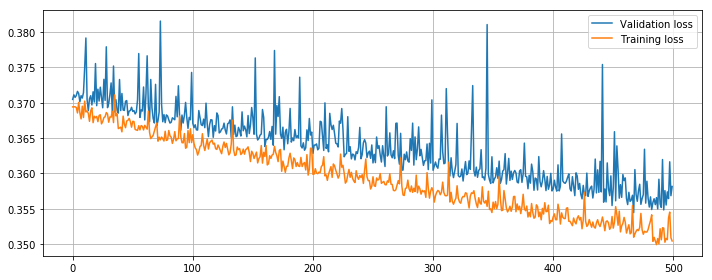

In [61]:
plt.figure(figsize=(10,4))
plt.subplot(111)
plt.plot(autoencoder.history.history['val_loss'], label='Validation loss')
plt.plot(autoencoder.history.history['loss'], label='Training loss')
plt.legend()
plt.grid()
plt.tight_layout()

In [53]:
from sklearn.preprocessing import LabelEncoder

In [62]:
encoder = Model([VL_input, VH_input], bottleneck)
code = encoder.predict([VL_encoded, VH_encoded])

le = LabelEncoder().fit(animals)
labels = le.transform(animals)

unique_labels = np.unique(labels)

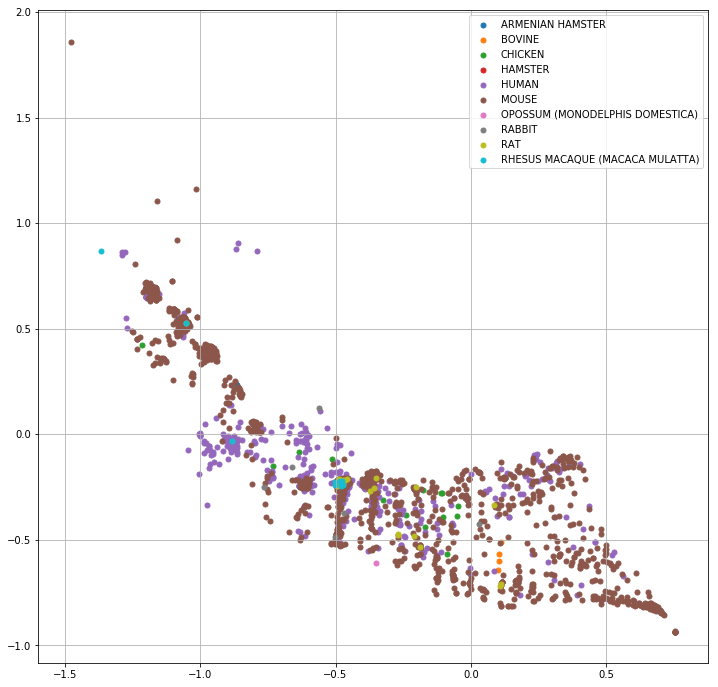

In [63]:
plt.figure(figsize=(12,12))
for x in range(unique_labels.size):
    mask_labels = labels == unique_labels[x]
    plt.scatter(code[mask_labels,0], code[mask_labels,1], marker='.', label=le.classes_[x], s=100)
# plt.ylim([-3,1])
# plt.xlim([-2.5,5])
plt.legend()
plt.grid()